<a href="https://colab.research.google.com/github/lauraredmondson/nma-eggplant-cobra/blob/master/MNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

first import everything you might need:

In [44]:
from keras.datasets import fashion_mnist, mnist
import keras
from keras import layers
from matplotlib import pyplot as plt
import numpy as np

Now import our dataset, let's also plot some images to see what we're dealing with:

Train: X = (60000, 28, 28), y = (60000,)
Test: X = (10000, 28, 28), y = (10000,)


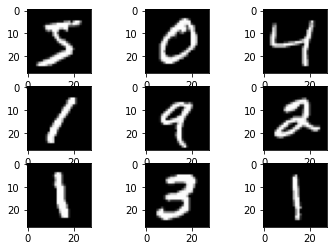

In [52]:
#(train_X, train_y), (test_X, test_y) = fashion_mnist.load_data()
(train_X, train_y), (test_X, test_y) = mnist.load_data()  # comment out this line and uncomment  the above to use fashion instead of digits 💃


print(f'Train: X = {train_X.shape}, y = {train_y.shape}')
print(f'Test: X = {test_X.shape}, y = {test_y.shape}')

for i in range(9):
  plt.subplot(330+1+i)
  plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))

plt.show()



IMPORTANT: Our dataset is currently using pixel values between 0 and 255 to express each image. Our network doesn't do great with those sorts of dimensions, so we are going to convert them to cover a distribution with $\mu = 0$ and $\sigma=1$ by deducting the mean and dividing by the standard deviation. We also make some other changes to match them to the in- and outputs of our network.

In [53]:
train_X = train_X.astype('float32')   #currently X matrices are of data type int: need to convert here to stop python from complaining when we divide
train_X -= np.mean(train_X)           #deduct the mean: now mean == 0
train_X /= np.std(train_X)            #divide by the std: now std == 1
train_X = np.expand_dims(train_X, -1) #add an extra dimension because our Conv2D layer wills it so

test_X = test_X.astype('float32')     #see above
test_X -= np.mean(test_X)
test_X /= np.std(test_X)
test_X = np.expand_dims(test_X, -1)

train_y = keras.utils.to_categorical(train_y, 10) #turn our y vectors (currently ints 0-9) into 'one-hot' vectors to match the categorical output of our network
test_y = keras.utils.to_categorical(test_y, 10)

Now let's build our model! This is the place to add (or change) stuff before training it! Just make sure your first layer has `input_shape = 28,28,1` and your output layer is size 10 and uses softmax.

In [54]:
model = keras.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1))) # A convolutional layer
model.add(layers.MaxPooling2D(pool_size=(2, 2)))                                                                  # A pooling layer to filter out some noise
model.add(layers.Flatten())                                                                                       # A flatten layer is required to move from 2dConv to densely connected layers
model.add(layers.Dense(100,activation='relu'))                                                                    # This layer actually has most of our weights!
model.add(layers.Dense(10, activation="softmax"))                                                                 # Output uses another activation function and is size==output_size (==10)

opt = keras.optimizers.SGD(lr=0.01, momentum=0.9) # you can try other optimizers like Adam or Nesterov (see keras.io for documentation) or change the hyperparameters
model.summary()
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 100)               540900    
_________________________________________________________________
dense_20 (Dense)             (None, 10)                1010      
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
_________________________________________________________________


Model looks good. Let's train it!

In [55]:
batch_size = 128
epochs = 30

history = model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 3s 62us/step - loss: 0.2779 - accuracy: 0.9189 - val_loss: 0.1116 - val_accuracy: 0.9663
Epoch 2/30
54000/54000 [==============================] - 3s 61us/step - loss: 0.1084 - accuracy: 0.9662 - val_loss: 0.0742 - val_accuracy: 0.9788
Epoch 3/30
54000/54000 [==============================] - 3s 61us/step - loss: 0.0726 - accuracy: 0.9779 - val_loss: 0.0579 - val_accuracy: 0.9837
Epoch 4/30
54000/54000 [==============================] - 3s 60us/step - loss: 0.0537 - accuracy: 0.9828 - val_loss: 0.0530 - val_accuracy: 0.9863
Epoch 5/30
54000/54000 [==============================] - 3s 60us/step - loss: 0.0430 - accuracy: 0.9864 - val_loss: 0.0520 - val_accuracy: 0.9852
Epoch 6/30
54000/54000 [==============================] - 3s 61us/step - loss: 0.0338 - accuracy: 0.9887 - val_loss: 0.0479 - val_accuracy: 0.9858
Epoch 7/30
54000/54000 [==============================] - 3s 61us/ste

Our model does insanely well very quickly (and even hits 100% Accuracy on the training set)! However, 30 epochs is clearly too long a training time, as we can see the network's `val_accuracy` and `val_loss` plateau early on.

One question that remains is, how well does it do on the test set?

In [50]:
score = model.evaluate(test_X, test_y) # generates predictions and compares them with ground truth test_y all in one easy step!
print("Test loss:", score[0])
print("Test accuracy:", score[1])

10000/10000 [==============================] - 1s 90us/step
Test loss: 0.41872877460047603
Test accuracy: 0.9121000170707703


Not bad! Now, we might want to visualize the history of training to better help us select a good training length, and evaluate the influence of hyperparameters etc.
Luckily keras again has very neat functionality for this, as it stores the history of the model's fitting in the history object defined above with `history=model.fit()`. We can plot some of its features with matplotlib to visualise the training history!

<function matplotlib.pyplot.show>

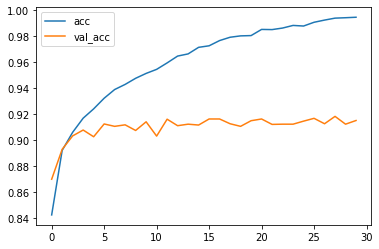

In [51]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.show

Go team eggplant-cobra!